In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicClassifier
import pandas as pd
import random

: 

In [6]:
import graphviz
from sklearn.utils import check_random_state
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold



## Defining useful functions

In [ ]:
#Function to change multiclass classification to 1 vs all
def multiclass_to_binary(labels, most_common_id):
    to_binary = lambda val: 1 if val == most_common_id else 0
    to_binary_vec = np.vectorize(to_binary)

    labels_1vsall = to_binary_vec(labels)

    return labels_1vsall

## Pulling Full Sample Dataset from CSV

In [258]:
import os
path = os.getcwd()
par = os.path.abspath(os.path.join(path, os.pardir))

data_path = os.path.join(par,'3_generate_features','final_feature_array.csv')
label_path = os.path.join(par,'3_generate_features','final_label_array.csv')

os.path.isfile(data_path)


True

In [259]:
#Turn into DF
prototype_df = pd.read_csv(data_path)
label_df = pd.read_csv(label_path)
prototype_df.head()

,Prototype
0,Anatase#TiO2
1,Cristobalite#SiO2
2,Rutile#TiO2
3,Laves(2H)#MgZn2
4,Quartz(low)#SiO2


In [277]:
prototype_df.head()

,e1_Number,e1_MendeleevNumber,e1_AtomicWeight,e1_MeltingT,e1_Column,e1_Row,e1_CovalentRadius,e1_Electronegativity,e1_NsValence,e1_NpValence,e1_NdValence,e1_NfValence,e1_NValence,e1_NsUnfilled,e1_NpUnfilled,e1_NdUnfilled,e1_NfUnfilled,e1_NUnfilled,e1_GSvolume_pa,e1_GSbandgap,e1_GSmagmom,e1_SpaceGroupNumber,e2_Number,e2_MendeleevNumber,e2_AtomicWeight,e2_MeltingT,e2_Column,e2_Row,e2_CovalentRadius,e2_Electronegativity,e2_NsValence,e2_NpValence,e2_NdValence,e2_NfValence,e2_NValence,e2_NsUnfilled,e2_NpUnfilled,e2_NdUnfilled,e2_NfUnfilled,e2_NUnfilled,e2_GSvolume_pa,e2_GSbandgap,e2_GSmagmom,e2_SpaceGroupNumber
0,22.0,43.0,47.867000,1941.0,4.0,4.0,160.0,1.54,2.0,0.0,2.0,0.0,4.0,0.0,0.0,8.0,0.0,8.0,16.690000,0.000,0.000023,194.0,22.0,43.0,47.867000,1941.0,4.0,4.0,160.0,1.54,2.0,0.0,2.0,0.0,4.0,0.0,0.0,8.0,0.0,8.0,16.690000,0.000,0.000023,194.0
1,14.0,78.0,28.085500,1687.0,14.0,3.0,111.0,1.90,2.0,2.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,4.0,20.440000,0.773,0.000000,227.0,14.0,78.0,28.085500,1687.0,14.0,3.0,111.0,1.90,2.0,2.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,4.0,20.440000,0.773,0.000000,227.0
2,25.0,52.0,54.938045,1519.0,7.0,4.0,139.0,1.55,2.0,0.0,5.0,0.0,7.0,0.0,0.0,5.0,0.0,5.0,10.487586,0.000,0.000310,217.0,25.0,52.0,54.938045,1519.0,7.0,4.0,139.0,1.55,2.0,0.0,5.0,0.0,7.0,0.0,0.0,5.0,0.0,5.0,10.487586,0.000,0.000310,217.0
3,12.0,68.0,24.305000,923.0,2.0,3.0,141.0,1.31,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,22.890000,0.000,0.000000,194.0,12.0,68.0,24.305000,923.0,2.0,3.0,141.0,1.31,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,22.890000,0.000,0.000000,194.0
4,14.0,78.0,28.085500,1687.0,14.0,3.0,111.0,1.90,2.0,2.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,4.0,20.440000,0.773,0.000000,227.0,14.0,78.0,28.085500,1687.0,14.0,3.0,111.0,1.90,2.0,2.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,4.0,20.440000,0.773,0.000000,227.0


In [262]:
#Dataframe convert label into categorical variable for classification
label_name = 'Prototype'
label_df[label_name]= pd.Categorical(label_df[label_name])
label_df['numeric_label'] = label_df[label_name].cat.codes

label_df.head()


,Prototype,numeric_label
0,Anatase#TiO2,18
1,Cristobalite#SiO2,114
2,Rutile#TiO2,298
3,Laves(2H)#MgZn2,201
4,Quartz(low)#SiO2,287


## Don't run these cells

In [246]:
# #Feature Set (excluding relevant ids)
# feature_df = prototype_df[prototype_df.columns.difference(relevant_ids)]
# feature_df.head()

,type0_AtomicWeight,type0_Column,type0_CovalentRadius,type0_Electronegativity,type0_GSbandgap,type0_GSmagmom,type0_GSvolume_pa,type0_MeltingT,type0_MendeleevNumber,type0_NUnfilled,type0_NValence,type0_NdUnfilled,type0_NdValence,type0_NfUnfilled,type0_NfValence,type0_NpUnfilled,type0_NpValence,type0_NsUnfilled,type0_NsValence,type0_Number,type0_Row,type0_SpaceGroupNumber,type0_comp,type0_oxi,type0_sym,type1_AtomicWeight,type1_Column,type1_CovalentRadius,type1_Electronegativity,type1_GSbandgap,type1_GSmagmom,type1_GSvolume_pa,type1_MeltingT,type1_MendeleevNumber,type1_NUnfilled,type1_NValence,type1_NdUnfilled,type1_NdValence,type1_NfUnfilled,type1_NfValence,type1_NpUnfilled,type1_NpValence,type1_NsUnfilled,type1_NsValence,type1_Number,type1_Row,type1_SpaceGroupNumber,type1_comp,type1_oxi,type1_sym
47,35.453000,17,102,3.16,2.493,0.00000,24.497500,171.60,94,1,7,0,0,0,0,1,5,0,2,17,3,64,Cl1,-1,Cl,132.905452,1,244,0.79,0.000,0.0,115.765000,301.59,5,1,1,0,0,0,0,0,0,1,1,55,6,229,Cs1,1,Cs
7071,132.905452,1,244,0.79,0.000,0.00000,115.765000,301.59,5,1,1,0,0,0,0,0,0,1,1,55,6,229,Cs1,1,Cs,32.065000,16,105,2.58,2.202,0.0,25.786875,388.36,88,2,6,0,0,0,0,2,4,0,2,16,3,70,S1,-2,S
7534,132.905452,1,244,0.79,0.000,0.00000,115.765000,301.59,5,1,1,0,0,0,0,0,0,1,1,55,6,229,Cs1,1,Cs,30.973762,15,107,2.19,1.625,0.0,22.570238,317.30,83,3,5,0,0,0,0,3,3,0,2,15,3,2,P1,-3,P
7672,54.938045,7,139,1.55,0.000,0.00031,10.487586,1519.00,52,5,7,5,5,0,0,0,0,0,2,25,4,217,Mn1,2,Mn,32.065000,16,105,2.58,2.202,0.0,25.786875,388.36,88,2,6,0,0,0,0,2,4,0,2,16,3,70,S1,-2,S
8500,14.006700,15,71,3.04,6.437,0.00000,14.768750,63.05,82,3,5,0,0,0,0,3,3,0,2,7,2,194,N1,-3,N,92.906380,5,164,1.60,0.000,0.0,18.180000,2750.00,47,7,5,6,4,0,0,0,0,1,1,41,5,229,Nb1,3,Nb


In [248]:
#Remove all string/weird variable representations from df (need to automate this maybe later)
# bad_columns = ['type0_comp', 'type0_sym', 'type1_comp', 'type1_sym']
# feature_df = feature_df[feature_df.columns.difference(bad_columns)]

# feature_df.head()


,type0_AtomicWeight,type0_Column,type0_CovalentRadius,type0_Electronegativity,type0_GSbandgap,type0_GSmagmom,type0_GSvolume_pa,type0_MeltingT,type0_MendeleevNumber,type0_NUnfilled,type0_NValence,type0_NdUnfilled,type0_NdValence,type0_NfUnfilled,type0_NfValence,type0_NpUnfilled,type0_NpValence,type0_NsUnfilled,type0_NsValence,type0_Number,type0_Row,type0_SpaceGroupNumber,type0_oxi,type1_AtomicWeight,type1_Column,type1_CovalentRadius,type1_Electronegativity,type1_GSbandgap,type1_GSmagmom,type1_GSvolume_pa,type1_MeltingT,type1_MendeleevNumber,type1_NUnfilled,type1_NValence,type1_NdUnfilled,type1_NdValence,type1_NfUnfilled,type1_NfValence,type1_NpUnfilled,type1_NpValence,type1_NsUnfilled,type1_NsValence,type1_Number,type1_Row,type1_SpaceGroupNumber,type1_oxi
47,35.453000,17,102,3.16,2.493,0.00000,24.497500,171.60,94,1,7,0,0,0,0,1,5,0,2,17,3,64,-1,132.905452,1,244,0.79,0.000,0.0,115.765000,301.59,5,1,1,0,0,0,0,0,0,1,1,55,6,229,1
7071,132.905452,1,244,0.79,0.000,0.00000,115.765000,301.59,5,1,1,0,0,0,0,0,0,1,1,55,6,229,1,32.065000,16,105,2.58,2.202,0.0,25.786875,388.36,88,2,6,0,0,0,0,2,4,0,2,16,3,70,-2
7534,132.905452,1,244,0.79,0.000,0.00000,115.765000,301.59,5,1,1,0,0,0,0,0,0,1,1,55,6,229,1,30.973762,15,107,2.19,1.625,0.0,22.570238,317.30,83,3,5,0,0,0,0,3,3,0,2,15,3,2,-3
7672,54.938045,7,139,1.55,0.000,0.00031,10.487586,1519.00,52,5,7,5,5,0,0,0,0,0,2,25,4,217,2,32.065000,16,105,2.58,2.202,0.0,25.786875,388.36,88,2,6,0,0,0,0,2,4,0,2,16,3,70,-2
8500,14.006700,15,71,3.04,6.437,0.00000,14.768750,63.05,82,3,5,0,0,0,0,3,3,0,2,7,2,194,-3,92.906380,5,164,1.60,0.000,0.0,18.180000,2750.00,47,7,5,6,4,0,0,0,0,1,1,41,5,229,3


## Continue here

In [ ]:
#Find class frequencies
label_counts = label_df['numeric_label'].value_counts()
#See pandas categorical mapping
label_dict = dict(enumerate(label_df['Prototype'].cat.categories))

label_counts[0]




: 

In [291]:
#Nan 

# #Defining feature matrix
# feature_df = prototype_df

# #Putting labels and features together for nan removal
# feature_df['numeric_label'] = label_df['numeric_label']

# #Remove nans
# print(f'Rows before: {feature_df.shape[0]}')
# feature_df = feature_df.dropna()
# print(f'Rows after: {feature_df.shape[0]}')

# labels = feature_df['numeric_label'].to_numpy()


# features = feature_df.to_numpy()

# #Fixing up feature names removing a particular string
# feature_names = list(feature_df.columns)

# labels.shape


Rows before: 8758
Rows after: 8748


(8748,)

In [292]:
labels_2vsall = multiclass_to_binary(labels, most_common_id=203)

## Applying Symbolic Regression


In [321]:
#Set rng seed and permutation of data examples for training
rng = check_random_state(0)

#Check number of dominant class examples
n_dominant_class = np.sum(labels_2vsall)
#Dominant class boolean index
dominant_class_mask = labels_2vsall==1

#Dominant class indexing to grab for training/test set (we want 50/50 representation)
SR_features_train = features[dominant_class_mask,:]
SR_target_train = labels_2vsall[dominant_class_mask]

#Grabbing all negative examples of which we're going to grab a number equal to the number of dominant class
SR_negative_train = features[~dominant_class_mask,:]
SR_negative_target = labels_2vsall[~dominant_class_mask]

#Apply subsampling. We grab a random subset from the negative set of the same size as the positive examples
subsample_idx = rng.permutation(SR_negative_target.size)[:SR_target_train.size]

SR_features = np.concatenate((SR_features_train, SR_negative_train[subsample_idx,:]),axis=0)
SR_targets = np.concatenate((SR_target_train, SR_negative_target[subsample_idx]), axis=0)



# train_idx = perm[:train_len]
# test_idx = perm[train_len:]

# #Overall set

# #Train Set
# SR_target_train = labels_2vsall[train_idx]
# SR_features_train = features[train_idx,:]

# #Test Set
# SR_target_test = labels_2vsall[test_idx]
# SR_features_test = features[test_idx,:]

In [326]:
#Generate 20-80 splits (we're going to just use one of these for the initial pass)

skf = StratifiedKFold(n_splits=5)
splits = skf.split(SR_features,SR_targets)




In [327]:
#Use first generator output for train/test splits
SR_train_idx, SR_test_idx = next(splits)

In [328]:
#Defining train test splits using train/test indices
SR_features_train = SR_features[SR_train_idx]
SR_target_train = SR_targets[SR_train_idx]

SR_features_test = SR_features[SR_test_idx]
SR_target_test = SR_targets[SR_test_idx]


In [332]:
SR_classifier = SymbolicClassifier(population_size = 1000, generations=100,
                         tournament_size = 20,
                         parsimony_coefficient=0.001,
                         p_crossover = 0.85,
                         p_subtree_mutation = 0.01,
                         p_point_mutation = 0.01,
                         p_hoist_mutation = 0.1,
                         feature_names=feature_names,
						 random_state=1)

SR_classifier.fit(SR_features_train, SR_target_train)

SymbolicClassifier(feature_names=['e1_Number', 'e1_MendeleevNumber',
                                  'e1_AtomicWeight', 'e1_MeltingT', 'e1_Column',
                                  'e1_Row', 'e1_CovalentRadius',
                                  'e1_Electronegativity', 'e1_NsValence',
                                  'e1_NpValence', 'e1_NdValence',
                                  'e1_NfValence', 'e1_NValence',
                                  'e1_NsUnfilled', 'e1_NpUnfilled',
                                  'e1_NdUnfilled', 'e1_NfUnfilled',
                                  'e1_NUnfilled', 'e1_GSvolume_pa',
                                  'e1_GSbandgap', 'e1_GSmagmom',
                                  'e1_SpaceGroupNumber', 'e2_Number',
                                  'e2_MendeleevNumber', 'e2_AtomicWeight',
                                  'e2_MeltingT', 'e2_Column', 'e2_Row',
                                  'e2_CovalentRadius', 'e2_Electronegativity', ...],
                   generations=100, p_crossover=0.85, p_hoist_mutation=0.1,
                   random_state=1)

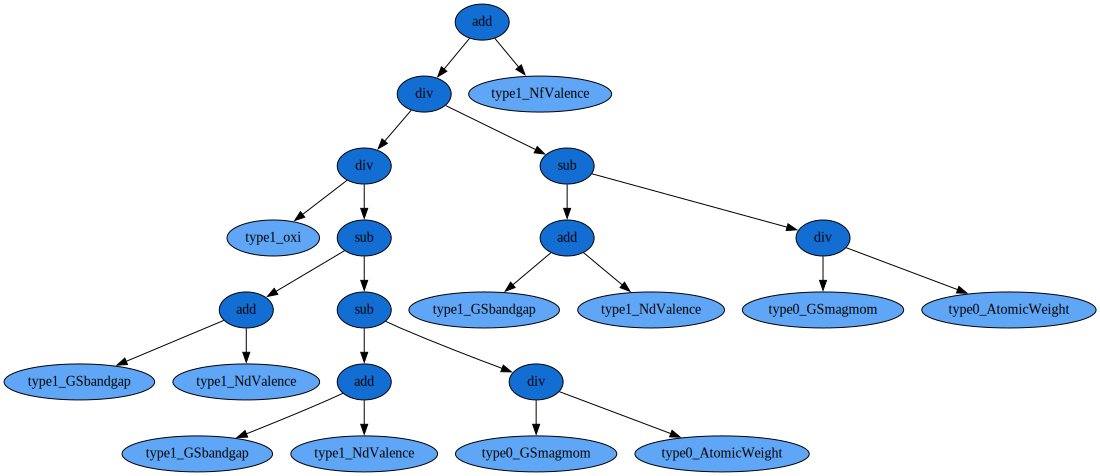

In [255]:
#Visualize as graph

dot_data = SR_classifier._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph.render('images/ex4_tree', format='png', cleanup=True)
graph

In [334]:
SR_classifier.score(SR_features_test, SR_target_test)


0.7487765089722676

## Interpreting Symbolic Expression Visually

In [253]:
from sympy import *
from IPython.display import display, Math

#Dictionary for functions in gplearn
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

def prettify(classifier):
    expression = sympify((str(SR_classifier._program)), locals=converter)
    exp_latek = latex(expression)
    ax = plt.axes([0,0,0.3,0.3]) #left,bottom,width,height
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    
    plt.text(0.4, 0.4,'$%s$'%exp_latek, size = 50)

    


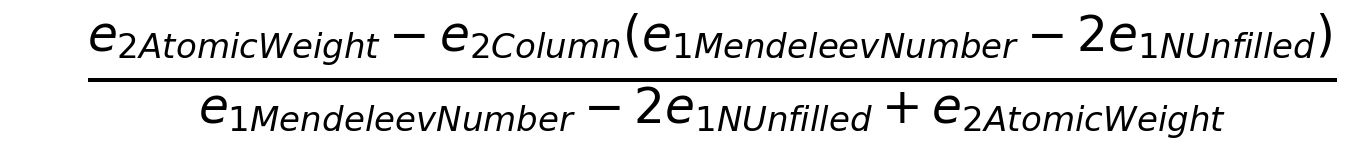

In [333]:
#Display prettified expression
prettify(SR_classifier)

## Random Forest Benchmark

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [339]:
#Naive random forest
naive_rf = RandomForestClassifier(max_depth=5, n_estimators=10)
naive_rf.fit(SR_features_train,SR_target_train)



RandomForestClassifier(max_depth=5, n_estimators=10)

In [335]:
#Stratified K fold (maintain class balance)

skf = StratifiedKFold(n_splits=5)

for i, (train_idx, test_idx) in enumerate(skf.split(SR_features,SR_targets)):
    train_features_i = features[train_idx]
    train_labels_i = labels_2vsall[train_idx]

    test_features_i = features[test_idx]
    test_labels_i = labels_2vsall[test_idx]

    #Fit naive rf model
    naive_rf_i = RandomForestClassifier(max_depth=5, n_estimators=10)
    naive_rf_i.fit(train_features_i, train_labels_i)

    #Fit on k-folded validation set
    test_score_i = naive_rf_i.score(test_features_i, test_labels_i)

    print(f'Fold: {i}')
    print(f'Test: {test_score_i}')





Fold: 0
Test: 0.9902120717781403
Fold: 1
Test: 0.9265905383360522
Fold: 2
Test: 0.9902120717781403
Fold: 3
Test: 1.0
Fold: 4
Test: 0.9918300653594772


In [340]:
importances = naive_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in naive_rf.estimators_], axis = 0)


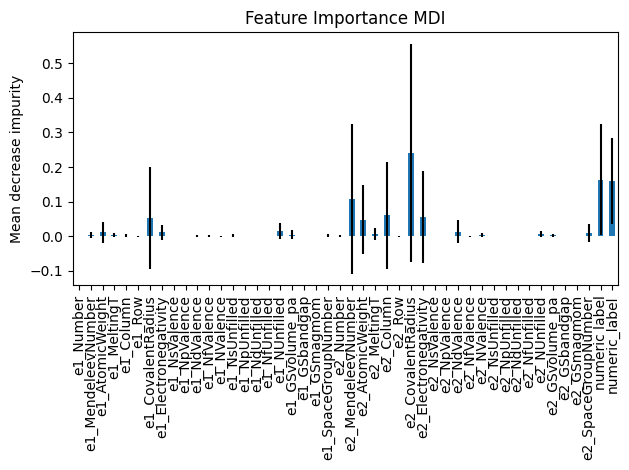

In [341]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

forest_importances = pd.Series(importances, index = feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax=ax)
ax.set_title('Feature Importance MDI')
ax.set_ylabel('Mean decrease impurity')
fig.tight_layout()



In [ ]:
#TRIM THIS TOMORROW BASED ON FI 

## Cancer DSET (IGNORE THIS IS FOR REFERENCE)


In [193]:
rng = check_random_state(0)
cancer = load_breast_cancer()
perm = rng.permutation(cancer.target.size)
cancer.data = cancer.data[perm]
cancer.target = cancer.target[perm]

In [194]:
cancer.feature_names


array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [109]:
function_set = ['add', 'sub', 'mul', 'div', 'sqrt',
                'abs', 'neg', 'inv', 'max', 'min']

In [195]:
#Defining function set to use in symbolic classification

est = SymbolicClassifier(parsimony_coefficient=.01,
                         feature_names=cancer.feature_names,
                         random_state=1)
est.fit(cancer.data[:400], cancer.target[:400])

SymbolicClassifier(feature_names=array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23'),
                   parsimony_coefficient=0.01, random_state=1)

In [217]:
a = sympify('mul(a,b)', locals=converter)
a

a*b

In [205]:
est.hall_of_fame

In [111]:
y_true = cancer.target[400:]
y_score = est.predict_proba(cancer.data[400:])[:,1]
roc_auc_score(y_true, y_score)



0.9693786982248521

In [112]:
y_score

array([9.87333236e-01, 9.93255872e-01, 8.99437669e-02, 3.04637276e-01,
       6.02068985e-01, 9.23997536e-01, 9.87121616e-01, 9.94963460e-01,
       9.75590513e-01, 5.37858724e-01, 2.09411395e-02, 1.75012653e-02,
       3.02336598e-13, 9.57427501e-01, 5.43537457e-02, 6.09270162e-05,
       5.01672128e-01, 9.91639538e-01, 9.67743117e-01, 7.18487645e-01,
       9.50344059e-01, 5.96739523e-01, 5.71379721e-02, 9.90992282e-01,
       8.24958161e-01, 9.19846544e-01, 4.29071461e-01, 9.98715303e-01,
       5.62561330e-01, 2.27917215e-01, 7.23944395e-02, 9.97739994e-01,
       3.25215070e-03, 8.58417314e-01, 1.32715182e-06, 9.13530591e-01,
       8.88514912e-01, 6.61662375e-01, 9.97139033e-01, 5.72548424e-02,
       9.65785159e-01, 1.61758596e-05, 3.86244528e-01, 5.81764241e-04,
       9.68138024e-01, 1.00000000e+00, 1.09334878e-08, 1.20111679e-01,
       9.99953589e-01, 8.34983648e-01, 3.69815279e-01, 8.96200789e-01,
       6.02741066e-01, 7.44641139e-01, 9.99999680e-01, 6.75342556e-01,
      